In [1]:
import numpy as np
from scipy import sparse
from scipy.special import assoc_laguerre, sph_harm_y
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
from scipy.sparse import kron, kronsum
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time
import math

### Resources

- Computational Quantum Mechanics, Izaac & Wang, chapter 9 and 10
- Mr. P Solver video https://www.youtube.com/watch?v=hxGA1Je1P-s&t=533s

Hydrogen Atom Potential

$$
V(r) = \frac{Ze^2}{4\pi\epsilon_0 r}
$$
$Z$ is the nuclear charge, so for hydrogen that is equal to $+1$

We also use atomic units, so $e=1$, $\epsilon_0=1$, $\hbar=1$, and $m_e=1$

The schrodinger equation is 
$$
H \psi = E\psi
$$

The Hamiltonain is

$$
H=-\frac{\hbar^2}{2m}\nabla^2 + V(x,y,z)
$$
and expanded out
$$
H=-\frac{\hbar^2}{2m}\bigg(\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}+\frac{\partial^2}{\partial z^2}\bigg) + V(x,y,z)
$$

This technique involves using the finite difference method to approximate the second derivative that appears in the Laplacian. The second derivative of $\psi$ at site $j$ is given by

$$
-\frac{\hbar^2}{2m}\frac{\psi_{j+1}-2\psi_j+\psi_{j-1}}{\Delta x^2} + V_j\psi_j=E\psi_j+\mathcal{O}(\Delta x^2)
$$

For a discrete basis of 4 points, then the matrix would look like
$$
D=
\begin{pmatrix}
2k+V_1 & -k & 0 & 0 \\
-k & 2k+V_2 & -k & 0 \\
0 & -k & 2k+V_3 & -k \\
0 & 0 & -k & 2k+V_4 \\
\end{pmatrix}
$$

where $k=\frac{\hbar^2}{2m\Delta x^2}$

The potential matrix $V$ is a diagonal matrix, so you can add it to the finite difference matrix.

A key note is that this formula uses sites to the left $\psi_{j-1}$ and right $\psi_{j+1}$ which means it is not defined at the boundaries $\psi_0$ and $\psi_N$, so the matrix dimensions are $(N-2,N-2)$.

The Hamiltonian is therefore represented as
$$
H = -\frac{-\hbar^2}{2m}\bigg(\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}+\frac{\partial^2}{\partial z^2}\bigg)= -\frac{-\hbar^2}{2m}[D \oplus D \oplus D]
$$

where the Kronecker sum is defined as 
$$
D \oplus D = D \otimes I + I \otimes D
$$

If the dimensions of $D$ are $(n,n)$ then the Kronecker sum will produce a matrix that is $(n^2, n^2)$. 

In this notebook, the dimensions of $H$ are $((N-2)^2,(N-2)^2) \times ((N-2),(N-2)) = ((N-2)^3,(N-2)^3)$

In [2]:
hbar = 1 #6.626e-34 / (2*3.14159265)
m = 1 
L = 20 # distance in all dimensions, essentially in units of Bohr radius a0
N = 100 # number of points in all dimensions

print(f"Matrix size: ({(N-2)**3},{(N-2)**3})")

xmin = -L/2
xmax = L/2
ymin = -L/2
ymax = L/2
zmin = -L/2
zmax = L/2
xT = (xmax-xmin)
yT = (ymax-ymin)
zT = (zmax-zmin)

dx = xT / N
dy = yT / N
dz = zT / N

main_diagonal = np.full(N-2, 2)
off_diagonal = np.full(N-2-1, -1)
positions = [-1,0,1]

kx = -hbar**2/(2*m*dx**2)
H1dx = kx * diags([off_diagonal, main_diagonal, off_diagonal], positions)

ky = -hbar**2/(2*m*dy**2)
H1dy = ky * diags([off_diagonal, main_diagonal, off_diagonal], positions)

kz = -hbar**2/(2*m*dz**2)
H1dz = kz * diags([off_diagonal, main_diagonal, off_diagonal], positions)

H2D = kronsum(H1dx, H1dy)

H3D = kronsum(H2D, H1dz)

V = np.zeros((N-2,N-2,N-2))
for i in range(0, N-2):
    for j in range(0, N-2):
        for k in range(0, N-2):
            x = i*dx-xT/2
            y = j*dy-yT/2
            z = k*dz-zT/2
            V[i,j,k] = -dx**2/((4*np.pi)*np.sqrt(x**2+y**2+z**2 + 1e-10))

V = diags(V.reshape((N-2)*(N-2)*(N-2)), (0))

H3D = H3D + V
nEigenvalues = 20
startTime = time.time()
print("Begin solve...")
evals, evecs = eigsh(H3D, k=nEigenvalues)
print(f"Total computation time: {time.time() - startTime:.2f} s")


Matrix size: (941192,941192)
Begin solve...
Total computation time: 249.75 s


In [3]:
nStateLevel = 2

state = evecs[:,nStateLevel]

prob = np.abs(state)**2

# normalize values for plot
prob /= prob.max()

xx = np.linspace(xmin, xmax, N-2)
yy = np.linspace(ymin, ymax, N-2)
zz = np.linspace(zmin, zmax, N-2)
X,Y,Z = np.meshgrid(xx, yy, zz, indexing='ij')

fig = go.Figure(data=go.Isosurface(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=prob.flatten(),
    # cmin=0,
    # cmax=1,
    isomin=0.01,
    isomax=1.0,
    opacity=0.4, # needs to be small to see through all surfaces
    surface_count=8,
    colorscale='jet',
    caps= dict(x_show=False, y_show=False, z_show=False), # no caps
    )
)
fig.update_layout(scene_xaxis_showticklabels=True,
                  scene_yaxis_showticklabels=True,
                  scene_zaxis_showticklabels=True,
                  title=f'Hydrogen atom\nn={nStateLevel}',
                  )
fig.update_layout(scene=dict(
    xaxis=dict(range=[-L/2, L/2]),
    yaxis=dict(range=[-L/2, L/2]),
    zaxis=dict(range=[-L/2, L/2]),
))
fig.show(renderer="browser")

Plot the eigenvalues

n=0, E=-396.2691
n=1, E=-149.9624
n=2, E=-149.9250
n=3, E=-149.9250
n=4, E=-149.9250
n=5, E=-149.8872
n=6, E=-149.8872
n=7, E=-149.8872
n=8, E=-149.8621
n=9, E=-149.8621
n=10, E=-149.8609
n=11, E=-149.8494
n=12, E=-149.8243
n=13, E=-149.8243
n=14, E=-149.8243
n=15, E=-149.8243
n=16, E=-149.8243
n=17, E=-149.8243
n=18, E=-149.7865
n=19, E=-149.7865


Text(0, 0.5, 'Energy')

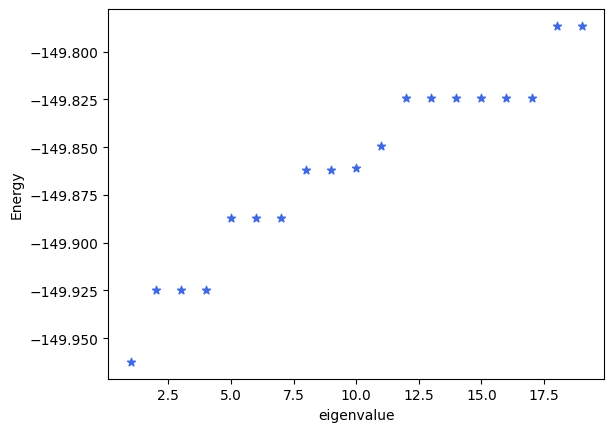

In [4]:
for i, e in enumerate(evals):
    print(f"n={i}, E={e:.4f}")

xplot = [i+1 for i in range(nEigenvalues-1)]
plt.scatter(xplot, evals[1:], marker='*', color='royalblue')
plt.xlabel("eigenvalue")
plt.ylabel("Energy")
# plt.grid()

Plot the analytical functions for the hydrogen atom

In [5]:
def hydrogen_wavefunction(n,l,m,x,y,z):
    rho = np.sqrt(x**2+y**2+z**2)
    theta = np.arctan(np.sqrt(x**2+y**2)/z)
    phi = np.arctan(y/x)
    Lmn = assoc_laguerre(rho, n-l-1, 2*l+1)
    Ylm = sph_harm_y(l, m, theta, phi)
    return np.sqrt((2/n)**3*(math.factorial(n-l-1)/(2*n*math.factorial(n+l))))*np.exp(-rho/2)*rho**l*Lmn*Ylm

In [ ]:
L = 20
N = 200 # greater than 200 crashed in Jupyter notebook inline and browser

xmin = -L/2
xmax = L/2
ymin = -L/2
ymax = L/2
zmin = -L/2
zmax = L/2

xx = np.linspace(xmin, xmax, N)
yy = np.linspace(ymin, ymax, N)
zz = np.linspace(zmin, zmax, N)
X,Y,Z = np.meshgrid(xx, yy, zz, indexing='ij')

n = 4
l = 3
m = 1

x1d = X.flatten()
y1d = Y.flatten()
z1d = Z.flatten()

psi = hydrogen_wavefunction(n,l,m,x1d,y1d,z1d)

psi = np.abs(psi)**2

psi /= psi.max()
print(psi.max())

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=psi.flatten(),
    # cmin=0,
    # cmax=1,
    isomin=0.01,
    isomax=1.0,
    opacity=0.4, # needs to be small to see through all surfaces
    surface_count=6,
    colorscale='jet',
    caps= dict(x_show=False, y_show=False, z_show=False), # no caps
    slices_z=dict(show=True, locations=[L/2])
    )
)
fig.update_layout(scene_xaxis_showticklabels=True,
                  scene_yaxis_showticklabels=True,
                  scene_zaxis_showticklabels=True,
                  title=f'Hydrogen atom\nn={n},l={l},m={m}',
                  )
fig.update_layout(scene=dict(
    xaxis=dict(range=[-L/2, L/2]),
    yaxis=dict(range=[-L/2, L/2]),
    zaxis=dict(range=[-L/2, L/2]),
))
fig.show(renderer='browser')

1.0


Plot an xy plane slice

Text(0, 0.5, 'Y')

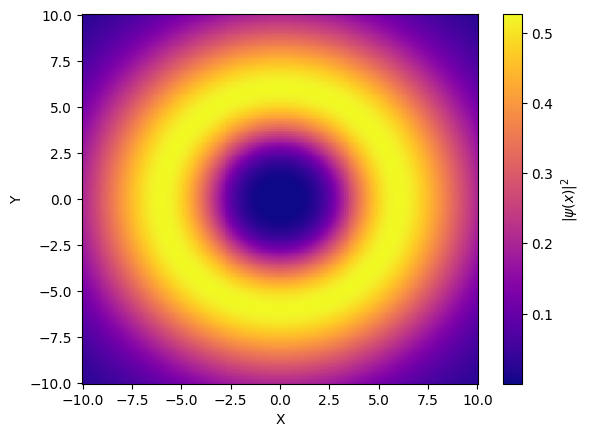

In [53]:
index = N//2
x2d = X[:,:,index]
y2d = Y[:,:,index]

psi = hydrogen_wavefunction(n,l,m,x1d,y1d,z1d)
psi = np.abs(psi)**2
psi /= psi.max()
psi3d = psi.reshape((N,N,N))
psi2d = psi3d[:,:,index]

contour = plt.pcolormesh(x2d, y2d, psi2d, cmap='plasma')
plt.colorbar(contour, label=r"$|\psi(x)|^2$")
plt.xlabel("X")
plt.ylabel("Y")

Plot a XZ slice

Text(0, 0.5, 'Z')

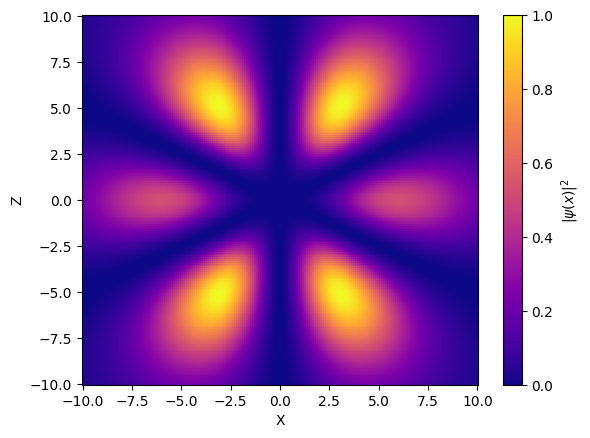

In [54]:
index = N//2
x2d = X[:,index,:]
z2d = Z[:,index,:]

psi = hydrogen_wavefunction(n,l,m,x1d,y1d,z1d)
psi = np.abs(psi)**2
psi /= psi.max()
psi3d = psi.reshape((N,N,N))
psi2d = psi3d[:,index,:]

contour = plt.pcolormesh(x2d, z2d, psi2d, cmap='plasma', vmin=0, vmax=1)
plt.colorbar(contour, label=r"$|\psi(x)|^2$")
plt.xlabel("X")
plt.ylabel("Z")